Logistic Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging

class LogisticRegression:
    THRESHOLD = 0.5
    PRINT_COST_INTERVAL = 50

    def __init__(self, learning_rate=0.01, num_iterations=1000, tolerance=1e-4, cost_function="cross_entropy", evaluation_metric='f1_score'):
        """Initialize the LogisticRegression model.

        Parameters:
            learning_rate (float): The learning rate for gradient descent.
            num_iterations (int): The number of iterations for gradient descent.
            tolerance (float): The convergence tolerance.
            cost_function (str): The cost function to use ('cross_entropy' or 'squared_error').
        """
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.tolerance = tolerance
        self.theta = None
        self.cost_function = cost_function
        self.evaluation_metric = evaluation_metric
        
        # Initialize the logger
        self.logger = logging.getLogger(__name__)
        self.logger.setLevel(logging.INFO)
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')

        # Create a StreamHandler to output log messages to the console
        stream_handler = logging.StreamHandler()
        stream_handler.setLevel(logging.INFO)
        stream_handler.setFormatter(formatter)
        self.logger.addHandler(stream_handler)

    def sigmoid(self, z):
        """Sigmoid activation function."""
        return 1 / (1 + np.exp(-z))

    def calculate_gradient(self, X, y, theta):
        """Calculate the gradient of the cost function.

        Parameters:
            X (numpy.ndarray): The training data.
            y (numpy.ndarray): The target labels.
            theta (numpy.ndarray): The model parameters.

        Returns:
            numpy.ndarray: The gradient vector.
        """
        m = len(y)
        z = np.dot(X, theta)
        h = self.sigmoid(z)
        gradient = np.dot(X.T, (h - y)) / m
        return gradient

    def cross_entropy_cost(self, X, y, theta):
        """Calculate the cross-entropy cost.

        Parameters:
            X (numpy.ndarray): The training data.
            y (numpy.ndarray): The target labels.
            theta (numpy.ndarray): The model parameters.

        Returns:
            float: The cost value.
        """
        m = len(y)
        z = np.dot(X, theta)
        h = self.sigmoid(z)
        cost = -(1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
        return cost

    def squared_error_cost(self, X, y, theta):
        """Calculate the squared error cost.

        Parameters:
            X (numpy.ndarray): The training data.
            y (numpy.ndarray): The target labels.
            theta (numpy.ndarray): The model parameters.

        Returns:
            float: The cost value.
        """
        m = len(y)
        z = np.dot(X, theta)
        h = self.sigmoid(z)
        cost = (1/(2*m)) * np.sum((h - y) ** 2)
        return cost
    
    def find_optimal_threshold(self, X_val, y_val, evaluation_metric=None):
        """Find the optimal threshold that maximizes F1-score on the validation data.

        Parameters:
            X_val (numpy.ndarray): The validation data.
            y_val (numpy.ndarray): The validation target labels.

        Returns:
            tuple[float,float]: (Threshold, Metric)
        """
        predicted_probabilities = self.predict_proba(X_val)
        # Generate a range of threshold candidates
        threshold_candidates = np.linspace(0, 1, num=len(X_val))
        
        if evaluation_metric is None:
            evaluation_metric = self.evaluation_metric
        # Calculate Metric for all candidates
        # f1_scores = []
        best_threshold = None
        best_metric_value = None
        for threshold in threshold_candidates:
            predicted_labels = (predicted_probabilities >= threshold).astype(int)
            true_positives = np.sum(predicted_labels * y_val)
            predicted_positives = np.sum(predicted_labels)
            actual_positives = np.sum(y_val)

            # # Calculate F1-score
            # precision = true_positives / (predicted_positives + 1e-10)
            # recall = true_positives / (actual_positives + 1e-10)
            # f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
            # f1_scores.append(f1)
            
            if evaluation_metric == "f1_score":
                # Calculate F1-score
                """The F1-score is a metric that balances precision and recall. 
                    Precision is the ratio of true positive predictions to the total positive predictions made by the model, 
                    and recall is the ratio of true positive predictions to the total actual positive examples. 
                """
                precision = true_positives / (predicted_positives + 1e-10)
                recall = true_positives / (actual_positives + 1e-10)
                f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
                metric_value = f1
            elif evaluation_metric == "accuracy":
                # Calculate accuracy
                accuracy = np.mean(predicted_labels == y_val)
                metric_value = accuracy
            # Add more cases for other evaluation metrics as needed
            else:
                raise ValueError("Invalid evaluation metric specified.")
        
            if best_metric_value is None or metric_value > best_metric_value:
                best_threshold = threshold
                best_metric_value = metric_value
            
        # # Find the index of the threshold that maximizes F1-score
        # best_threshold_index = np.argmax(f1_scores)
        # best_threshold = threshold_candidates[best_threshold_index]
        # best_f1_score = f1_scores[best_threshold_index]
        
        return best_threshold, best_metric_value
    
    def fit(self, X, y, X_val=None, y_val=None):
        """Fit the logistic regression model to the training data and find the optimal threshold.

        Parameters:
            X (numpy.ndarray): The training data.
            y (numpy.ndarray): The target labels.
            X_val (numpy.ndarray): The validation data (optional).
            y_val (numpy.ndarray): The validation target labels (optional).

        Returns:
            numpy.ndarray: The learned model parameters (theta).
        """
        m, n = X.shape
        self.theta = np.zeros(n)  # Initialize weights with zeros
        prev_cost = float('inf')  # ensures that the first iteration will certainly lead to a decrease in the cost function.

        for iteration in range(self.num_iterations):
            gradient = self.calculate_gradient(X, y, self.theta)
            self.theta -= self.learning_rate * gradient

            # Calculate the cost function based on the chosen method
            if self.cost_function == "cross_entropy":
                cost = self.cross_entropy_cost(X, y, self.theta)
            elif self.cost_function == "squared_error":
                cost = self.squared_error_cost(X, y, self.theta)
            else:
                raise ValueError("Invalid cost function specified.")

            # Log cost to monitor convergence
            if iteration % self.PRINT_COST_INTERVAL == 0:
                self.logger.info(f"Iteration {iteration}: Cost Function = {cost:.5f}")

            # Check for convergence based on tolerance
            if abs(prev_cost - cost) < self.tolerance:
                self.logger.info(f"Converged after {iteration + 1} iterations.")
                break
            
            prev_cost = cost
            
        # If validation data is provided, find the optimal threshold
        if X_val is not None and y_val is not None:
            optimal_threshold, metric_value = self.find_optimal_threshold(X_val, y_val, self.evaluation_metric)
            self.logger.info(f"Optimal Threshold: {optimal_threshold:.5f}  {self.evaluation_metric.capitalize()}: {metric_value:.5f}")

        return self.theta

    def predict(self, X, threshold=None):
        """Make predictions on new data.

        Parameters:
            X (numpy.ndarray): The input data.
            threshold (float): The decision threshold for classification.

        Returns:
            numpy.ndarray: The binary predictions (0 or 1).
        """
        if threshold is None:
            threshold = self.THRESHOLD  # Use the default threshold if not provided
        z = np.dot(X, self.theta)
        h = self.sigmoid(z)
        predictions = (h >= threshold).astype(int)
        return predictions

    def predict_proba(self, X):
        """Calculate predicted probabilities.

        Parameters:
            X (numpy.ndarray): The input data.

        Returns:
            numpy.ndarray: The predicted probabilities.
        """
        z = np.dot(X, self.theta)
        h = self.sigmoid(z)
        return h


In [2]:
import pandas as pd
df = pd.read_csv("./datasets/heartdisease.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
categorical = df.select_dtypes(include=['object']).columns.to_list()
numerical = df.select_dtypes(include=['number']).columns.to_list()

# Get the number of unique values in each column
unique_counts = df.nunique()

# Filter for columns with less than 10 unique values
columns_with_less_than_10_unique = unique_counts[unique_counts < 10]
encoding_df = df[columns_with_less_than_10_unique.index].drop(columns=["HeartDisease"])
# print(encoding_df.columns.to_list())

# Get distinct values for all columns
distinct_values = [[col, encoding_df[col].unique()] for col in encoding_df.columns]
# Create a DataFrame from the list of distinct values
distinct_df = pd.DataFrame(distinct_values, columns=['Column Name', 'Distinct Values'])
print(distinct_df)

# # Print distinct values in each column
# for column in encoding_df.columns:
#     distinct_values = encoding_df[column].unique()
#     print(f"Distinct values in {column}: {distinct_values}")

      Column Name      Distinct Values
0             Sex               [M, F]
1   ChestPainType  [ATA, NAP, ASY, TA]
2       FastingBS               [0, 1]
3      RestingECG    [Normal, ST, LVH]
4  ExerciseAngina               [N, Y]
5        ST_Slope     [Up, Flat, Down]


In [4]:
dataset = df.copy()
print("dataset columns:",list(dataset.columns), sep="\n")
print("dataset shape:",dataset.shape, sep="\n")
print("total #features with target feature:",len(dataset.columns.to_list()))
target_column = "HeartDisease"
print("target feature:",target_column)
print('')

# Define the split ratio (e.g., 80% train, 20% test)
split_ratio = 0.8
# Calculate the number of rows for the training set
train_size = int(len(df) * split_ratio)
# Create a random permutation of row indices
indices = np.random.permutation(len(df))
# Split the indices into training and testing indices
train_indices, test_indices = indices[:train_size], indices[train_size:]
# Create the training and testing DataFrames
X_train_df = dataset.drop(columns=[target_column]).iloc[train_indices]
X_val_df = dataset.drop(columns=[target_column]).iloc[test_indices]
y_train_df = dataset[target_column].iloc[train_indices]
y_val_df = dataset[target_column].iloc[test_indices]

# Optionally, reset the index for the new DataFrames if needed
X_train_df.reset_index(drop=True, inplace=True)
X_val_df.reset_index(drop=True, inplace=True)
y_train_df.reset_index(drop=True, inplace=True)
y_val_df.reset_index(drop=True, inplace=True)
print("X_train:",X_train_df[:2].to_numpy(), sep="\n") 
print("y_train:",y_train_df[:2].to_numpy(), sep="\n")
print("X_tain Shape:",X_train_df.shape)
print("y_tain Shape:",y_train_df.shape)
print('\nvalidation_data')
print(X_val_df.shape, y_val_df.shape, sep="\n")

dataset columns:
['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']
dataset shape:
(918, 12)
total #features with target feature: 12
target feature: HeartDisease

X_train:
[[57 'M' 'ASY' 140 214 0 'ST' 144 'Y' 2.0 'Flat']
 [28 'M' 'ATA' 130 132 0 'LVH' 185 'N' 0.0 'Up']]
y_train:
[1 0]
X_tain Shape: (734, 11)
y_tain Shape: (734,)

validation_data
(184, 11)
(184,)


In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

categorical_features = encoding_df.columns.to_list()
# Define your preprocessing steps
categorical_transformer = Pipeline(steps=[
    ('onehot-encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
                    ('onehot-transformer', categorical_transformer, categorical_features)])
# Create the full pipeline with preprocessing and the model
model = Pipeline(steps=[('data-preprocessor', preprocessor),
                        ('model', LogisticRegression(learning_rate=0.1, num_iterations=5000, 
                                    tolerance=1e-5, cost_function="squared_error", evaluation_metric='f1_score')
                         )])#, verbose=True)

In [6]:
X_val_df_transformed = model['data-preprocessor'].fit_transform(X_val_df)

model.fit(X_train_df, y_train_df, model__X_val=X_val_df_transformed, model__y_val=y_val_df)

2023-09-10 00:46:39,931 - INFO - Iteration 0: Cost Function = 0.12196
2023-09-10 00:46:39,945 - INFO - Iteration 50: Cost Function = 0.06571
2023-09-10 00:46:39,959 - INFO - Iteration 100: Cost Function = 0.05674
2023-09-10 00:46:39,973 - INFO - Iteration 150: Cost Function = 0.05395
2023-09-10 00:46:39,986 - INFO - Iteration 200: Cost Function = 0.05273
2023-09-10 00:46:40,000 - INFO - Converged after 249 iterations.
2023-09-10 00:46:40,026 - INFO - Optimal Threshold: 0.39891  F1_score: 0.87619


Pipeline(steps=[('data-preprocessor',
                 ColumnTransformer(transformers=[('onehot-transformer',
                                                  Pipeline(steps=[('onehot-encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'ChestPainType',
                                                   'FastingBS', 'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('model',
                 <__main__.LogisticRegression object at 0x000001AEA59D38B0>)])

In [7]:
theta = model.named_steps['model'].theta
theta

array([-0.39771439,  0.4744483 ,  0.96381565, -0.55951986, -0.27726973,
       -0.05029216, -0.4657496 ,  0.54248351, -0.01391802, -0.02570905,
        0.11636099, -0.59105358,  0.66778749,  0.21477474,  0.96467687,
       -1.1027177 ])

In [8]:
y_pred = model.predict(X_val_df)
y_pred_proba = model.predict_proba(X_val_df)
# Calculate accuracy
print(y_pred.shape, y_pred_proba.shape, sep="\n")
accuracy = np.mean(y_pred == y_val_df)
print(f"Accuracy: {accuracy*100:.2f}%")

(184,)
(184,)
Accuracy: 85.87%


In [9]:
# Define a function for inferencing with the model
def predict_with_model(input_data, model):
    if isinstance(input_data, dict):
        # If input is a dictionary, convert it to a DataFrame with a single row
        input_df = pd.DataFrame([input_data])
    elif isinstance(input_data, list):
        # If input is a list, check if it's a list of dictionaries or a list of scalar values
        if isinstance(input_data[0], dict):
            # If it's a list of dictionaries, convert it to a DataFrame
            input_df = pd.DataFrame(input_data)
        else:
            # If it's a list of scalar values, assume it's a single row of data
            # and convert it to a DataFrame with appropriate column names
            input_df = pd.DataFrame([input_data], columns=['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'])
    
    X_input = input_df
    # Make predictions on the input data
    try:
        predictions = model.predict(X_input)
        # Or, if you need class probabilities (for classifiers)
        probabilities = model.predict_proba(X_input)

        return predictions, probabilities  # Return the model's predictions
    except TypeError as te:
        predictions = model.predict(pd.DataFrame(input_data))
        probabilities = model.predict_proba(pd.DataFrame(input_data))
        
        return predictions, probabilities

# Example usage
# 1. Single dictionary
input_dict1 = {
    'Age': 58,
    'Sex': 'F',
    'ChestPainType': 'ATA',
    'RestingBP': 180,
    'Cholesterol': 393,
    'FastingBS': 0,
    'RestingECG': 'Normal',
    'MaxHR': 110,
    'ExerciseAngina': 'Y',
    'Oldpeak': 1.0,
    'ST_Slope': 'Flat'
}

# 2. List of dictionaries
input_dict2 = [
    {
        'Age': 58,
        'Sex': 'F',
        'ChestPainType': 'ATA',
        'RestingBP': 180,
        'Cholesterol': 393,
        'FastingBS': 0,
        'RestingECG': 'Normal',
        'MaxHR': 110,
        'ExerciseAngina': 'Y',
        'Oldpeak': 1.0,
        'ST_Slope': 'Flat'
    },
    {
        'Age': 23,
        'Sex': 'F',
        'ChestPainType': 'ata',
        'RestingBP': 180,
        'Cholesterol': 213,
        'FastingBS': 1,
        'RestingECG': 'Normal',
        'MaxHR': 119,
        'ExerciseAngina': 'N',
        'Oldpeak': 0.0,
        'ST_Slope': 'Flat'
    }
]

# 3. List of dictionaries with series
input_dict3 = {
        'Age': [58, 23],
        'Sex': ['F', 'F'],
        'ChestPainType': ['ATA', 'ata'],
        'RestingBP': [180, 180],
        'Cholesterol': [393, 213],
        'FastingBS': [0, 1],
        'RestingECG': ['Normal', 'Normal'],
        'MaxHR': [110, 119],
        'ExerciseAngina': ['Y', 'N'],
        'Oldpeak': [1.0, 0.0],
        'ST_Slope': ['Flat', 'Flat']
    }

# 4. List
input_list = [58, 'F', 'ATA', 180, 393, 0, 'Normal', 110, 'Y', 1.0, 'Flat']

output1, proba1 = predict_with_model(input_dict1, model)
output2, proba2 = predict_with_model(input_dict2, model)
output3, proba3 = predict_with_model(input_dict3, model)
output4, proba4 = predict_with_model(input_list, model)
print("PredictedLabel", "PredictedProbability", sep='\t')
print(output1, proba1, sep='\t\t')
print(output2, proba2, sep='\t\t')
print(output3, proba3, sep='\t\t')
print(output4, proba4, sep='\t\t')

PredictedLabel	PredictedProbability
[1]		[0.545814]
[1 1]		[0.545814   0.62073836]
[1 1]		[0.545814   0.62073836]
[1]		[0.545814]


Metrics

Available metrics: ['accuracy', 'precision', 'recall', 'f1_score']
Accuracy: 85.87%
Precision: 83.64%
Recall: 92.00%
F1_score: 87.62%
Confusion_matrix:
[[92 18]
 [ 8 66]]
ROC AUC Score: 0.91


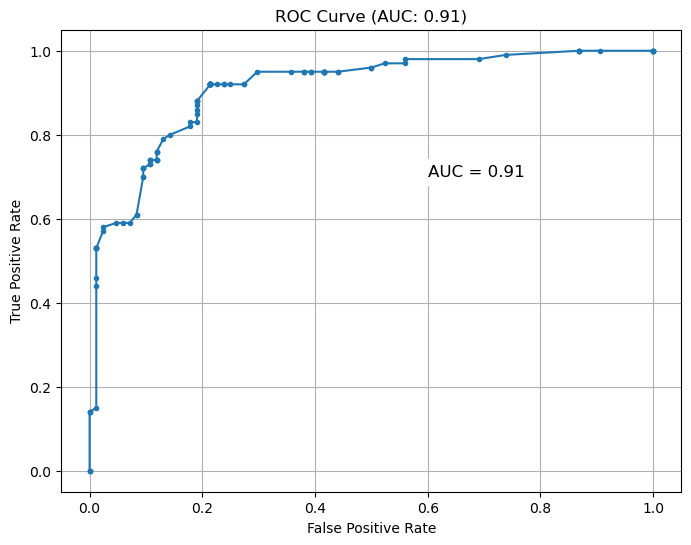

In [10]:
import matplotlib.pyplot as plt

def calculate_accuracy(y_pred, y_true):
    return np.mean(y_pred == y_true)

def calculate_precision(y_pred, y_true):
    true_positives = np.sum((y_pred == 1) & (y_true == 1))
    false_positives = np.sum((y_pred == 1) & (y_true == 0))
    return true_positives / (true_positives + false_positives)

def calculate_recall(y_pred, y_true):
    true_positives = np.sum((y_pred == 1) & (y_true == 1))
    false_negatives = np.sum((y_pred == 0) & (y_true == 1))
    return true_positives / (true_positives + false_negatives)

def calculate_f1_score(y_pred, y_true):
    precision = calculate_precision(y_pred, y_true)
    recall = calculate_recall(y_pred, y_true)
    return 2 * (precision * recall) / (precision + recall)

def calculate_confusion_matrix(y_pred, y_true):
    true_positives = np.sum((y_pred == 1) & (y_true == 1))
    false_positives = np.sum((y_pred == 1) & (y_true == 0))
    true_negatives = np.sum((y_pred == 0) & (y_true == 0))
    false_negatives = np.sum((y_pred == 0) & (y_true == 1))

    return np.array([[true_positives, false_positives], [false_negatives, true_negatives]])

def calculate_metric(metric_name, y_pred, y_true):
    if metric_name == "accuracy":
        return calculate_accuracy(y_pred, y_true)
    elif metric_name == "precision":
        return calculate_precision(y_pred, y_true)
    elif metric_name == "recall":
        return calculate_recall(y_pred, y_true)
    elif metric_name == "f1_score":
        return calculate_f1_score(y_pred, y_true)
    elif metric_name == "confusion_matrix":
        return calculate_confusion_matrix(y_pred, y_true)
    elif metric_name == "list_metrics":
        return ["accuracy", "precision", "recall", "f1_score"]
    else:
        raise ValueError(f"Invalid metric name. Available metrics: {', '.join(calculate_metric('list_metrics', None, None))}")

def calculate_metrics(y_pred, y_true):
    metrics = {}
    metrics["accuracy"] = calculate_accuracy(y_pred, y_true)
    metrics["precision"] = calculate_precision(y_pred, y_true)
    metrics["recall"] = calculate_recall(y_pred, y_true)
    metrics["f1_score"] = calculate_f1_score(y_pred, y_true)
    metrics["confusion_matrix"] = calculate_confusion_matrix(y_pred, y_true)
    return metrics

def calculate_roc_auc(y_prob, y_true, plot=False):
    thresholds = np.linspace(0, 1, 100)  # Threshold values
    tpr_list = []  # True Positive Rate (Sensitivity)
    fpr_list = []  # False Positive Rate

    for threshold in thresholds:
        y_pred_thresholded = (y_prob >= threshold).astype(int)
        true_positives = np.sum((y_pred_thresholded == 1) & (y_true == 1))
        false_positives = np.sum((y_pred_thresholded == 1) & (y_true == 0))
        true_negatives = np.sum((y_pred_thresholded == 0) & (y_true == 0))
        false_negatives = np.sum((y_pred_thresholded == 0) & (y_true == 1))

        tpr = true_positives / (true_positives + false_negatives)
        fpr = false_positives / (false_positives + true_negatives)

        tpr_list.append(tpr)
        fpr_list.append(fpr)

    auc = calculate_auc(tpr_list, fpr_list)
    print(f"ROC AUC Score: {auc:.2f}")
    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_list, tpr_list, linestyle='-', marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve (AUC: {auc:.2f})')  # Include AUC score in the title
        plt.grid(True)
        # Add AUC score as text annotation on the plot
        plt.annotate(f'AUC = {auc:.2f}', xy=(0.6, 0.4), xytext=(0.6, 0.7),
                    #  arrowprops=dict(facecolor='black', shrink=0.05),
                     fontsize=12, color='black', backgroundcolor='white')
        plt.show()

    return auc

def calculate_auc(tpr, fpr):
    auc = 0.0
    auc = round(abs(np.trapz(tpr, fpr)), 4)
    # for i in range(1, len(tpr)):
    #     width = fpr[i] - fpr[i - 1]
    #     height_avg = (tpr[i] + tpr[i - 1]) / 2
    #     auc += width * height_avg
    # return round(abs(auc), 4)
    return auc


# Example usage:
if __name__ == "__main__":
    # ... (training and prediction code)

    # Calculate and print the requested metric or list available metrics
    metric_name = "list_metrics"  # Change this to the metric you want to calculate or "list_metrics"
    y_test = y_val_df
    if metric_name == "list_metrics":
        print("Available metrics:", calculate_metric(metric_name, None, None))
    else:
        metric_value = calculate_metric(metric_name, y_pred, y_test)
        print(f"{metric_name.capitalize()}: {metric_value*100:.2f}%")

    # Calculate and print all eligible metrics
    calculated_metrics = calculate_metrics(y_pred, y_test)
    for metric_name, metric_value in calculated_metrics.items():
        if metric_name != "confusion_matrix":
            print(f"{metric_name.capitalize()}: {metric_value*100:.2f}%")
        else:
            print(f"{metric_name.capitalize()}:")
            print(metric_value)

    # Calculate and print ROC AUC score
    auc_score = calculate_roc_auc(y_pred_proba, y_test, plot=True)

Plots

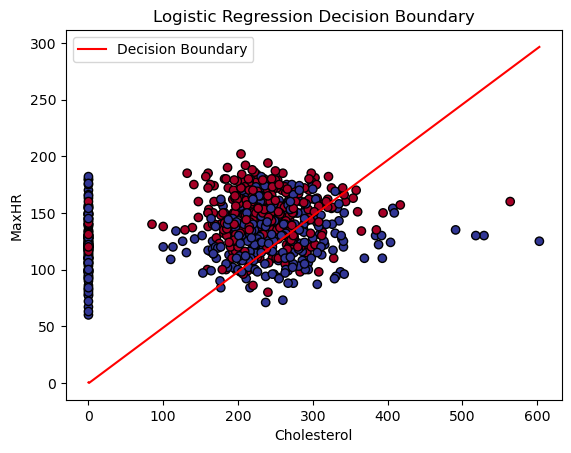

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the coefficients (weights) and intercept from the model
coefficients = model.named_steps['model'].theta

# Specify the names of the columns you want to use for visualization
feature1_name = 'Cholesterol'  # Replace with the actual column name
feature2_name = 'MaxHR'  # Replace with the actual column name

# Create a range of x values for plotting
x_values = np.linspace(X_train_df[feature1_name].min(), X_train_df[feature1_name].max(), len(X_train_df))

# Calculate the corresponding y values based on the decision boundary
intercept = -coefficients[0] / coefficients[2]
slope = -coefficients[1] / coefficients[2]
y_values = intercept + slope * x_values

# Plot the decision boundary
plt.plot(x_values, abs(y_values), label='Decision Boundary', color='red')

# Scatter plot for the training data
plt.scatter(X_train_df[feature1_name], X_train_df[feature2_name], c=y_train_df, cmap=plt.cm.RdYlBu, edgecolor='k')
plt.xlabel(f'{feature1_name}')
plt.ylabel(f'{feature2_name}')
plt.title('Logistic Regression Decision Boundary')
plt.legend()
plt.show()


In [44]:
dataset[dataset.select_dtypes(include='number').columns].describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


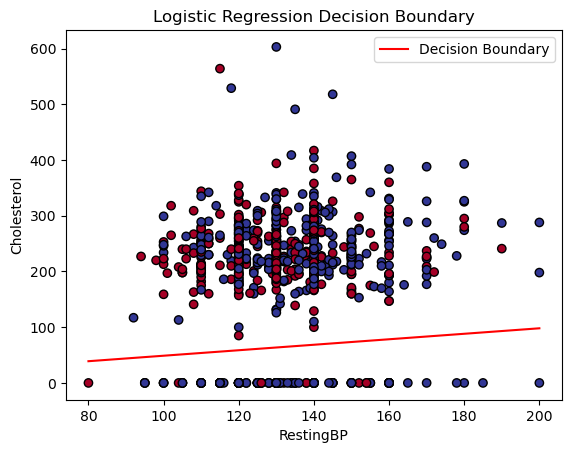

In [58]:
feature1_name = 'RestingBP' 
feature2_name = 'Cholesterol' 
X_train_df1 = X_train_df.copy()

# Extract the coefficients (weights) and intercept from the model
coefficients = model.named_steps['model'].theta
# Create a range of x values for plotting
x_values = np.linspace(X_train_df[feature1_name].min(), X_train_df[feature1_name].max(), len(X_train_df))

# Calculate the corresponding y values based on the decision boundary
intercept = -coefficients[0] / coefficients[2]
slope = -coefficients[1] / coefficients[2]
y_values = intercept + slope * x_values

# Plot the decision boundary
plt.plot(x_values, abs(y_values), label='Decision Boundary', color='red')

# Scatter plot for the training data
plt.scatter(X_train_df[feature1_name], X_train_df[feature2_name], c=y_train_df, cmap=plt.cm.RdYlBu, edgecolor='k')
plt.xlabel(f'{feature1_name}')
plt.ylabel(f'{feature2_name}')
plt.title('Logistic Regression Decision Boundary')
plt.legend()
plt.show()

In [70]:
# model.named_steps['data-preprocessor'].named_transformers_['onehot-transformer'].named_steps['onehot-encoder'].get_feature_names_out()